# 9. Regularization

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rhennig/EMA6938/blob/main/Notebooks/9.Regularization.ipynb)

(Based on https://www.nbshare.io/notebook/819279082/Regularization-Techniques-in-Linear-Regression-With-Python/)

Regularization is used to constrain (or regularize) the estimated coefficients of a model. This protects the model from overfitting on the training data. In the previous notebook on cross-validation we showed that overfitting of a polynomial regression can lead to poor prediction accuracy. Cross-validation is one approach to reduce overfitting. In that example, we used cross-validation to determine the optimal order of the polynomial for fitting the data.

Regularization lets us include more features into a model while avoiding to overfit through constraints of the optimized model coefficients. In other words, regularization is used to prevent overfitting but too much regularization can result in underfitting.

## Common Types of Regularization

A common approach of regularization is to shrink the model coefficients towards zero. We apply such a regularization constraint, we by simply adding a term to our loss function that measures the deviation of the model coefficients from zero.

1. LASSO regularization (absolute values of coefficients)
$$
C_\mathrm{LASSO} = C({\bf X}, {\bf y}, \beta) + \lambda \sum_{j=1}^k | \beta_j |.
$$

2. Ridge regularization (squared coefficients)
$$
C_\mathrm{Ridge} = C({\bf X}, {\bf y}, \beta) + \lambda \sum_{j=1}^k \beta_j^2.
$$


3. ElasticNet regularization (linear combination of absolute values and squared coefficients)
$$
C_\mathrm{ElasticNet} = C({\bf X}, {\bf y}, \beta) + \lambda \sum_{j=1}^k \left ( | \beta_j | + \beta_j^2 \right ).
$$

The variable λ is a hyperparameter to control the strength of our regularization. If λ = 0, we end up with linear regression with the usual loss function. If  λ = $\infty$, the regularization term would would dwarf the original loss function and drive all the coefficients to zero in the parameter optimization. Hence, a large λ results in underfitting.

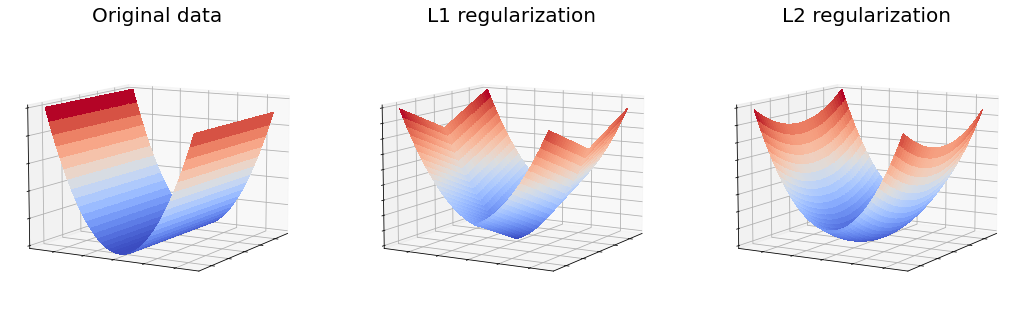

In [1]:
# Import matplotlib and numpy
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure(figsize=(18,8))

def plot_3d(sub, TitleText):
    ax = fig.add_subplot(1, 3, sub, projection='3d')
    surf = ax.plot_surface(X1, X2, Y, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.set_title(TitleText, fontsize=20)
    
    # Set camera position and remove tick labels
    ax.view_init(elev=10., azim=30)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

# Create a regular 2d mesh
X1 = np.arange(-5, 5, 0.25)
X2 = np.arange(-5, 5, 0.25)
X1, X2 = np.meshgrid(X1, X2)

# Plot original data
Y = 0.1*(X2*X2)
plot_3d(1, 'Original data')

# Plot L1 regularization
Y = 0.1*(X2*X2) + 0.2*(np.abs(X1)+np.abs(X2))
plot_3d(2, 'L1 regularization')

# Plot L2 ridge regularization 
Y = 0.1*(X2*X2) + 0.03*(X1*X1+X2*X2)
plot_3d(3, 'L2 regularization')

- The original data is constructured such that is has a valley along which the cost function does not change. This is also called soft degree of freedom, which can occur when the data does not constrain all model parameters equally well. These poorly constrained parameters can lead to a large variance in the prediction error on the validation set.

- The L$_1$ and L$_2$ regularization turn this valley in to minimum. For L$_1$ regularization, the minimum becomes a sharp point due to the use of the absolute value.

- The L$_2$ regularization leads to a quadratic mimimum, that can be found analytically in linear regression. For the likelihood, which is the negative of the cost function, the original data shows a ridge. The L$_2$ regularization turns that ridge into a nice peak in likelihood space, equivalent to a quadratic depression in the cost function.

## Feature Scaling

The various features in our data set may not be on the same scale. In that case, the model  coefficients are not going to be on the same scale either, resulting in different regularization on the various coefficients. Therefore, we need to normalize all the data to be on the same scale. This step is called feature scaling or data normalization.

## Example for Linear Regression

In [2]:
# Import the numpy, panda, sklearn, and matplotlib libraries
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 

In [3]:
# Function for plotting the errors
def plot_errors(lambdas, train_errors, test_errors, title):
    plt.figure(figsize=(12, 8))
    plt.plot(lambdas, train_errors, label="Training")
    plt.plot(lambdas, test_errors, label="Testing")
    plt.xlabel("$\\lambda$", fontsize=20)
    plt.ylabel("MSE", fontsize=20)
    plt.title(title, fontsize=24)
    plt.legend(fontsize=20)
    plt.show()

In [4]:
# Function to evaluate the model errors for a set of regularization parameters, lamda
def evaluate_model(Model, lambdas):
    training_errors = []  # we will store the error on the training set, for using each different lambda
    testing_errors  = []  # and the error on the testing set
    for l in lambdas:
        # in sklearn, they refer to lambda as alpha, the name is different in different literature
        # Model will be either Lasso, Ridge or ElasticNet
        model = Model(alpha=l, max_iter=1000) # we allow max number of iterations until the model converges
        model.fit(X_train, y_train)

        training_predictions = model.predict(X_train)
        training_mse = mean_squared_error(y_train, training_predictions)
        training_errors.append(training_mse)

        testing_predictions = model.predict(X_test)
        testing_mse = mean_squared_error(y_test, testing_predictions)
        testing_errors.append(testing_mse)
    return training_errors, testing_errors

In [5]:
# Generate a data set for machine learning
np.random.seed(seed=5)
x=np.linspace(0, 2, 300)
x=x+np.random.normal(0,.3,x.shape)
y=np.cos(x)+2*np.sin(x)+3*np.cos(x*2)+np.random.normal(0,1,x.shape)

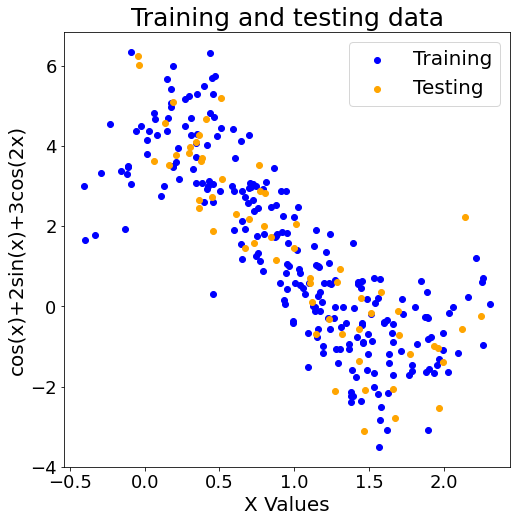

In [6]:
# Split the dataset into 80% for training and 20% for testing
x = x.reshape((x.size,1))
x_train,x_test,y_train,y_test = train_test_split(x, y, train_size=0.8, shuffle=True)

# Plot the training and testing dataset
fig,ax=plt.subplots(figsize=(8,8))
ax.scatter(x_train, y_train, color='blue', label='Training')
ax.scatter(x_test, y_test, color='orange', label='Testing')
ax.set_xlabel('X Values',fontsize=20)
ax.set_ylabel('cos(x)+2sin(x)+3cos(2x)',fontsize=20)
ax.set_title('Training and testing data',fontsize=25)
plt.legend(fontsize=20)
plt.show()

# Create the polynomial features for a large degree for the polynomials
degree  = 20
X_train = PolynomialFeatures(degree).fit_transform(x_train)
X_test  = PolynomialFeatures(degree).fit_transform(x_test)

### Lasso L$^1$ Regularization
$$
C_\mathrm{LASSO} = C({\bf X}, {\bf y}, \beta) + \lambda \sum_{j=1}^k | \beta_j |.
$$

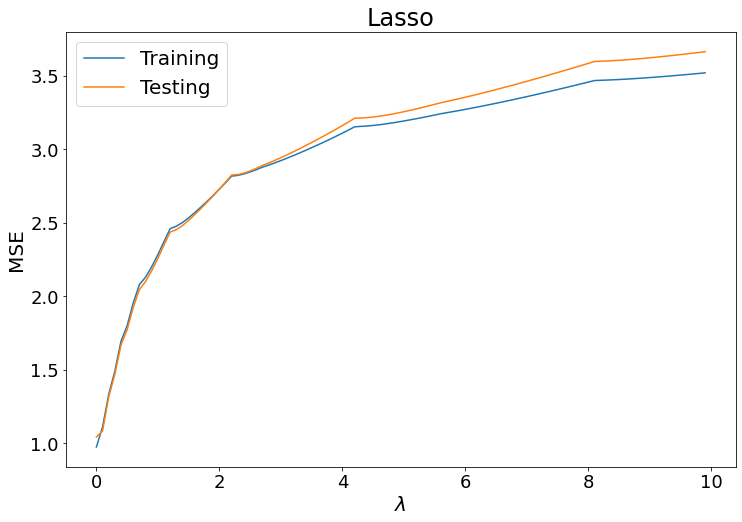

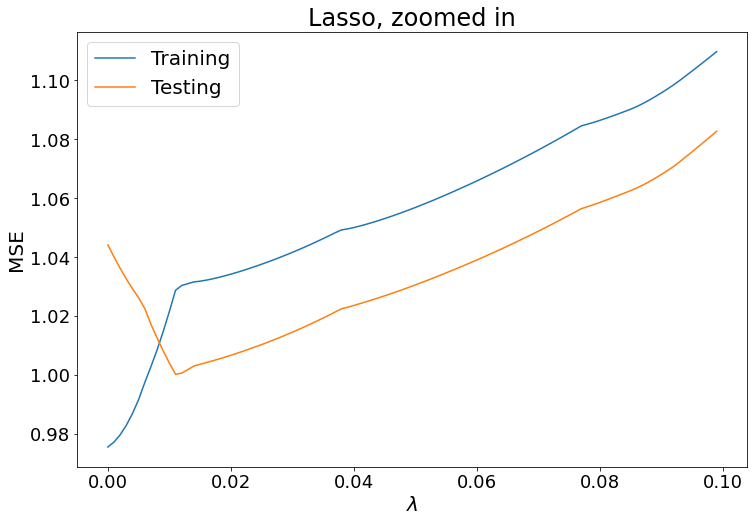

In [7]:
# Ignore warnings about convergence
import warnings
warnings.filterwarnings('ignore')

# Generate range of values for lambda from 0 (no-regularization) and (0.5 too much regularization)
lambdas = np.arange(0, 10, step=0.1)

lasso_train, lasso_test = evaluate_model(Lasso, lambdas)
plot_errors(lambdas, lasso_train, lasso_test, "Lasso")

# Generate range of values for a smaller range of lambda
lambdas = np.arange(0, 0.1, step=0.001)

lasso_train, lasso_test = evaluate_model(Lasso, lambdas)
plot_errors(lambdas, lasso_train, lasso_test, "Lasso, zoomed in")

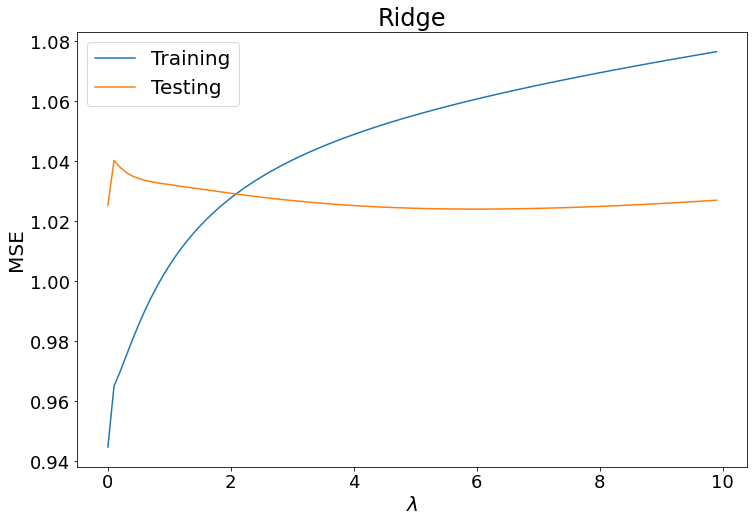

In [8]:
# let's generate different values for lambda from 0 (no-regularization) and (10 too much regularization)
lambdas = np.arange(0, 10, step=0.1)

ridge_train, ridge_test = evaluate_model(Ridge, lambdas)
plot_errors(lambdas, ridge_train, ridge_test, "Ridge")

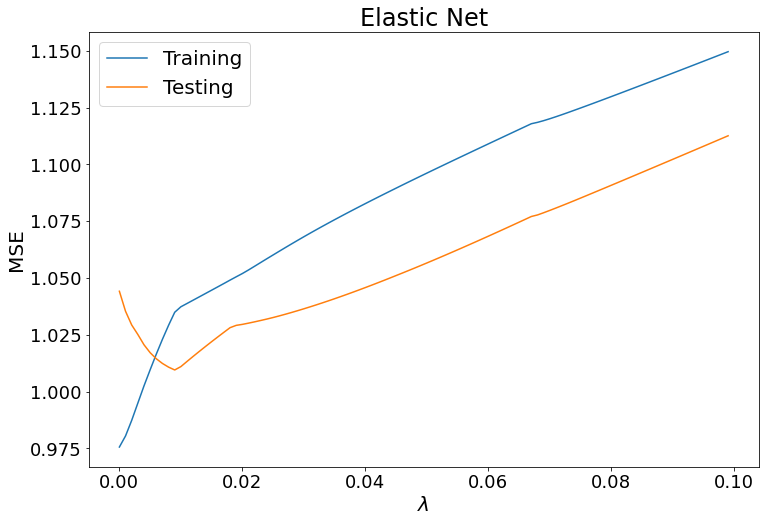

In [9]:
# Generate a range of values for lambda from 0 (no-regularization) to a larger value with probably too much regularization
lambdas = np.arange(0, 0.1, step=0.001)

elastic_train, elastic_test = evaluate_model(ElasticNet, lambdas)
plot_errors(lambdas, elastic_train, elastic_test, "Elastic Net")

## Regularization Techniques Comparison
- Lasso: will eliminate many features, and reduce overfitting in your linear model.
- Ridge: will reduce the impact of features that are not important in predicting your y values.
- Elastic Net: combines feature elimination from Lasso and feature coefficient reduction from the Ridge model to improve your model’s predictions.

## Cross Validation and Regularization 

The relationship between the training error / test error versus the model complexity has a U-shaped form. When learning a model, we have two goals:

1. Find the optimum on the model complexity axis where the U curve starts to go up again. This happens for the test error curve, even though the training error curve continues to go down overfitting the training data in high-complexity models.

2. Reduce the gap between the training error and test error curve.

Goal (1) is achieved by using cross validation, finding the fine balance between bias and variance.

Goal (2) is achieved by using regularization, raising the training error curve to be closer to the test error.